In [190]:
import os
import torch
import random
import numpy as np
from torchmetrics.segmentation import DiceScore
from torchmetrics.classification import BinaryJaccardIndex, BinaryPrecision, BinaryRecall
import matplotlib.pyplot as plt
import sys
import os
import cv2
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mask_generator.transforms import KorniaInferTransform
from mask_generator.config import Config
import mask_generator.settings as settings
from mask_generator.models import create_model
from mask_generator.utils import load_config_from_yaml

In [191]:
DATASET_CSV = "../Datasets/CARLANE/MoLane/molane_test.csv"
df = pd.read_csv(DATASET_CSV)
pairs_path = df[['image_path', 'mask_path']].values

print(f"Successfully loaded dataset with {len(pairs_path)} pairs of images and masks.")

Successfully loaded dataset with 1000 pairs of images and masks.


In [192]:
RUN_DIR = "../experiments/20250626_200538_96718eef57/"

config = load_config_from_yaml(os.path.join(RUN_DIR, settings.config_filename))

In [193]:
pair = random.choice(pairs_path)
print(f"Selected pair: {pair}")

original_image = cv2.imread(pair[0])
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

original_mask = cv2.imread(pair[1], cv2.IMREAD_GRAYSCALE)
original_mask = (original_mask >= 1).astype(np.uint8)

assert original_image.shape[:2] == original_mask.shape, "Image and mask must have the same dimensions."

Selected pair: ['/root/MaskGenerator/Datasets/CARLANE/MoLane/data/test/target/gray/0479_image.jpg'
 '/root/MaskGenerator/Datasets/CARLANE/MoLane/data/test/target/gray/0479_label.png']


In [194]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model, pad_divisor = create_model(config.model)
model.load_state_dict(torch.load(os.path.join(RUN_DIR, settings.model_filename), map_location=device))
model.eval()
model.to(device)

Using device: cuda


MyUNet(
  (encoders): ModuleList(
    (0): EncoderBlock(
      (conv): ConvBlock(
        (block): Sequential(
          (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_1): ReLU()
          (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_2): ReLU()
        )
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): EncoderBlock(
      (conv): ConvBlock(
        (block): Sequential(
          (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu_1): ReLU()
          (conv_2): Conv2d(64, 

In [195]:
transform = KorniaInferTransform(
    image_size=config.training.image_size,
    pad_divisor=pad_divisor,
    device=device,
)

preprocessed_image, preprocessed_mask = transform(image=original_image, mask=original_mask)

dice_metric = DiceScore(num_classes=2, average='macro').to(device)
iou_metric = BinaryJaccardIndex(threshold=0.5).to(device)
recall_metric = BinaryRecall(threshold=0.5).to(device)
precision_metric = BinaryPrecision(threshold=0.5).to(device)

with torch.no_grad():
    input_image, input_mask = preprocessed_image.unsqueeze(0).to(device), preprocessed_mask.unsqueeze(0).to(device)
    outputs = model(input_image)
    outputs = torch.sigmoid(outputs)
    outputs = (outputs > 0.5).float()

    dice_metric(outputs, input_mask)
    iou_metric(outputs, input_mask)
    recall_metric(outputs, input_mask)
    precision_metric(outputs, input_mask)

    dice_score = dice_metric.compute().item()
    iou_score = iou_metric.compute().item()
    recall_score = recall_metric.compute().item()
    precision_score = precision_metric.compute().item()

    print(f"Dice Score: {dice_score}")
    print(f"IoU Score: {iou_score}")
    print(f"Recall Score: {recall_score}")
    print(f"Precision Score: {precision_score}")

Dice Score: 0.8313897252082825
IoU Score: 0.7114344835281372
Recall Score: 0.9547991156578064
Precision Score: 0.7362306118011475


Plot saved to Plots/mask_plot_ad9bd74a-f1d2-43d4-9c60-17ef02ff3039.png


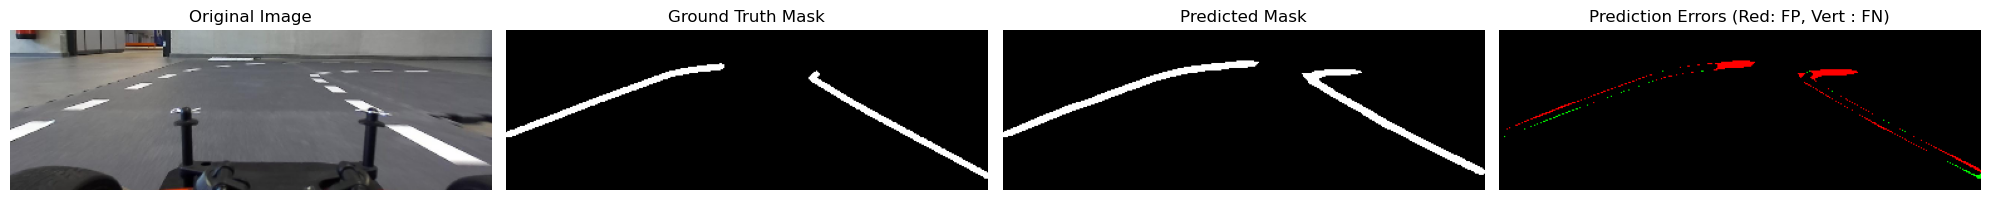

In [196]:
input_image_np = transform.to_image(preprocessed_image)
input_mask_np = transform.to_mask(preprocessed_mask)
mask_np = transform.to_mask(outputs)

fp = (mask_np == 255) & (input_mask_np == 0)
fn = (mask_np == 0) & (input_mask_np == 255)

diff_image = np.zeros((3, *input_image_np.shape[:2]), dtype=np.float32)

diff_image[0][fp] = 1.0  # Rouge pour Faux Positifs
diff_image[1][fn] = 1.0  # Vert pour Faux Négatifs

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Affichage de l'image originale
axes[0].imshow(input_image_np)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Affichage du masque réel
axes[1].imshow(input_mask_np, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Affichage du masque prédit
axes[2].imshow(mask_np, cmap='gray')
axes[2].set_title("Predicted Mask")
axes[2].axis('off')

axes[3].imshow(diff_image.transpose(1, 2, 0))  # Convertir en (H, W, C) pour l'affichage
axes[3].set_title("Prediction Errors (Red: FP, Vert : FN)")
axes[3].axis('off')

# Afficher l'ensemble
plt.tight_layout()
# plt.show()
os.makedirs("Plots", exist_ok=True)
import uuid
plot_filename = os.path.join("Plots", f"mask_plot_{uuid.uuid4()}.png")
plt.savefig(plot_filename)
print(f"Plot saved to {plot_filename}")

In [197]:
def line_post_processing(mask):
    # Dilate légèrement pour relier les brèches
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))  # kernel étiré horizontalement
    dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)

    # HoughLines pour extraire segments
    lines = cv2.HoughLinesP(dilated, rho=1, theta=np.pi/180, threshold=30,
                            minLineLength=20, maxLineGap=15)

    print(f"Number of lines detected: {len(lines) if lines is not None else 0}")

    # Création d'un masque vide
    processed_mask = np.zeros_like(mask, dtype=np.uint8)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(processed_mask, (x1, y1), (x2, y2), 1, thickness=2)

    return processed_mask

new_mask = line_post_processing(mask_np)

new_mask_tensor = torch.from_numpy(new_mask).unsqueeze(0).unsqueeze(0).to(input_mask.device).type_as(input_mask)
dice_metric.reset()
iou_metric.reset()
recall_metric.reset()
precision_metric.reset()
dice_metric(new_mask_tensor, input_mask)
iou_metric(new_mask_tensor, input_mask)
recall_metric(new_mask_tensor, input_mask)
precision_metric(new_mask_tensor, input_mask)

print(f"Dice Score after post-processing: {dice_metric.compute().item()}")
print(f"IoU Score after post-processing: {iou_metric.compute().item()}")
print(f"Recall Score after post-processing: {recall_metric.compute().item()}")
print(f"Precision Score after post-processing: {precision_metric.compute().item()}")


Number of lines detected: 29
Dice Score after post-processing: 0.7125976085662842
IoU Score after post-processing: 0.5535158514976501
Recall Score after post-processing: 0.9927455186843872
Precision Score after post-processing: 0.555763840675354


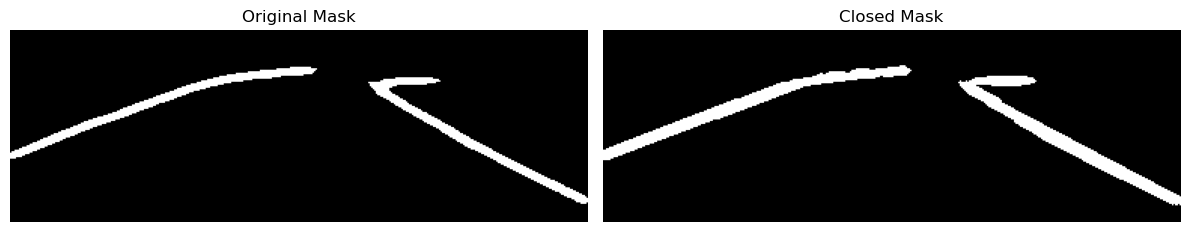

In [198]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(mask_np, cmap="gray")
axes[0].set_title("Original Mask")
axes[0].axis("off")
axes[1].imshow(new_mask, cmap="gray")
axes[1].set_title("Closed Mask")
axes[1].axis("off")
plt.tight_layout()
plt.show()